# Data Cleaning and Processing

In this notebook, we describe the key steps for cleaning and preprocessing the images collected for training the pose estimation model. We source the training images from the book "Pole Dancing for Fitness by Irina Kartaly", which is composed of around at least 300 unique movements, and use Google's MediaPipe library to extract pose landmarks from the images.

In [1]:
import os
import pandas as pd
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Filenames Organization

External images are saved in `data/external/*` and simply renamed chronologically for organisation.

In [ ]:
from src.data.preprocessing import batch_chronological_filenaming
target_dir = 'data/external/static-pole-fitness/'
batch_chronological_filenaming(target_dir)

## Batch Resampling

This is our function for batch resampling to check if the quality of pose estimation improves/worsens from bigger/smaller sizes.

In [ ]:
from src.data.preprocessing import batch_image_resampling

batch_image_resampling(
    input_dir = 'data/external/static-pole-fitness/',
    output_dir = 'data/interim/static-pole-fitness-2/',
    resampling_rate = 2)

## Pose Landmark Extraction for Preparing Training Data

Here we are automating the extraction of pose landmarks in preparation of our training data. Here below is Mediapipe's reference.

![Mediapipe Landmark Reference](notebooks/images/mediapipe_references.png)

### Extracting Pose Data: From RGBA-PNG to CSV

In this set up, we configure confidence level to 50% and model complexity to level 2. We do not need to concert

In [7]:
from src.data.pose_estimation import extract_static_pose, download_landmarks_csv, download_landmarks_png

input_dir = 'data/interim/static-pole-fitness-2/'
image_url_path = 'data/interim/static-pole-fitness-2/00001.png'
output_dir = 'data/processed/static-pole-fitness-2/'

if os.path.exists(image_url_path):
  landmarks, annotated_image = extract_static_pose(image_url_path,0.5,0.5,2)
  download_landmarks_csv(landmarks, image_url_path, output_dir)
  download_landmarks_png(annotated_image, image_url_path, output_dir)
else:
  print(f'{image_url_path} cannot be found.')

Here is a summary of what was collected. In total, each pose should contain 33 landmark points. In the annonated image, we color the points based on head, upper body and lower body regions.

In [12]:
# Overview of data collected
df = pd.read_csv('data/processed/static-pole-fitness-2/00001.csv')
df.describe()

,x,y,z,v
count,33.000000,33.000000,33.000000,33.000000
mean,0.392779,0.572583,-0.025901,0.838476
std,0.109520,0.236598,0.386758,0.275243
min,0.170152,0.096144,-0.814179,0.232454
25%,0.287361,0.531086,-0.216462,0.726408
50%,0.444942,0.675547,0.028465,0.993761
75%,0.458550,0.775361,0.157258,0.999725
max,0.509115,0.794538,0.627308,0.999983


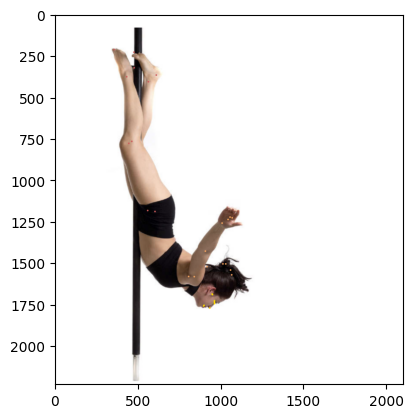

In [13]:
# Visualize Landmarks
sample = cv2.imread('data/processed/static-pole-fitness-2/00001.png')
plt.imshow(sample)

Now we're ready to automate the task!

In [10]:
def batch_process_png_files(input_dir, output_dir):
    count = 0
    error = 0
    for filename in os.listdir(input_dir):
        if filename.endswith(".png"):
            image_url_path = os.path.join(input_dir, filename)
        if os.path.exists(image_url_path):
            landmarks, annotated_image = extract_static_pose(image_url_path, 0.5, 0.5, 2)
            download_landmarks_csv(landmarks, image_url_path, output_dir)
            download_landmarks_png(annotated_image, image_url_path, output_dir)
            count += 1
        else:
            print(f"{image_url_path} cannot be found.")
            error += 1
        
    print(f"{count} images processed, {error} images skipped")
    
input_dir = "data/external/static-pole-fitness/"
output_dir = "data/processed/static-pole-fitness/"

batch_process_png_files(input_dir, output_dir)

452 images processed, 0 images skipped


In [15]:
test_input_dir = "data/interim/static-pole-fitness-2/"
test_output_dir = "data/processed/static-pole-fitness-2/"

batch_process_png_files(test_input_dir, test_output_dir)

450 images processed, 0 images skipped


## Analysis of Data Processed

In this section, we will analyze the trends and summarize the key attributes of the processed data.

Here are our basic defintions:

| Variables | Definition   |  Range and Implication |
|:-|:-|:-|
| $x$ | represents the horizontal position of the pose | $0 <= x <= 1$, where $x→0$ means more left, $x→1$ more right. <br> If $x > 1$, it only represents the predicted value of the landmark according to Mediapipe's model. |
| $y$ | represents the vertical position of the pose   | $0 <= y <= 1$, where $y→0$ means higher, $y→1$ means lower. <br>If $y > 1$, it only represents the predicted value of the landmark according to Mediapipe's model. |
| $z$ | represents the depth of a landmark from the camera | $-1 <= z <= 1$, where $z→1$ means further, $z→-1$ means closer |
| $v$ | describes how well the landmark can be seen in the camera image | $0 <= v <= 1$, where $v→1$ means more accurate. <br> If $v <= 0.3$, this already indicates a faulty landmark estimation, therefore should be excluded

We will choose samples that may represent the training data gathered:
1. Inverted Side Body Pose
2. Upright Full Body Pose
3. Twisted Full Body Pose
4. Upright Cropped Body Pose
5. Cropped Back Pose
   

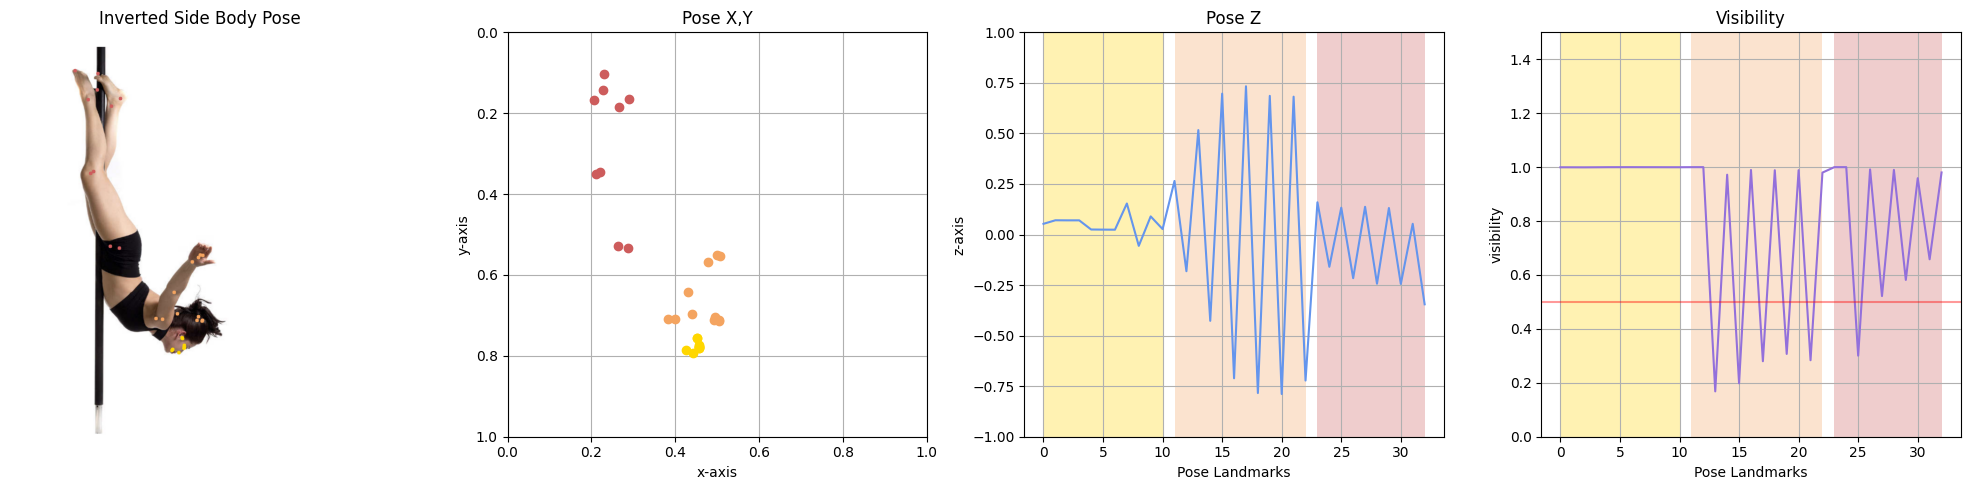

In [44]:
df1 = pd.read_csv('data/processed/static-pole-fitness/00001.csv')
orig_img1 = cv2.imread('data/processed/static-pole-fitness/00001.png')

x1 = df1['x'].to_numpy()
y1 = df1['y'].to_numpy()
z1 = df1['z'].to_numpy()
v1 = df1['v'].to_numpy()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

ax1.set_title("Inverted Side Body Pose")
ax1.imshow(orig_img1)
ax1.axis(False)

ax2.set_title("Pose X,Y")
ax2.plot(x1[0:10], y1[0:10], color=mcolors.CSS4_COLORS['gold'], label="head", marker='o', linestyle='None')
ax2.plot(x1[11:22], y1[11:22], color=mcolors.CSS4_COLORS['sandybrown'], label="upper body", marker='o', linestyle='None')
ax2.plot(x1[23:32], y1[23:32], color=mcolors.CSS4_COLORS['indianred'], label="lower body", marker='o', linestyle='None')
ax2.set_xlabel("x-axis")
ax2.set_ylabel("y-axis")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.invert_yaxis() #For better visualization
ax2.grid()

ax3.set_title("Pose Z")
ax3.axvspan(0, 10, facecolor=mcolors.CSS4_COLORS['gold'], alpha=0.3, label="head")
ax3.axvspan(11, 22, facecolor=mcolors.CSS4_COLORS['sandybrown'], alpha=0.3, label="upper body")
ax3.axvspan(23, 32, facecolor=mcolors.CSS4_COLORS['indianred'], alpha=0.3, label="lower body")
ax3.plot(z1, color=mcolors.CSS4_COLORS['cornflowerblue'], label="z-axis")
ax3.set_xlabel("Pose Landmarks")
ax3.set_ylabel("z-axis")
ax3.set_ylim(-1, 1)
ax3.grid()

ax4.set_title("Visibility")
ax4.plot(v1, color=mcolors.CSS4_COLORS['mediumpurple'], label="visibility")
ax4.axhline(y=0.5, color='red', alpha=0.4)
ax4.axvspan(0, 10, facecolor=mcolors.CSS4_COLORS['gold'], alpha=0.3, label="head")
ax4.axvspan(11, 22, facecolor=mcolors.CSS4_COLORS['sandybrown'], alpha=0.3, label="upper body")
ax4.axvspan(23, 32, facecolor=mcolors.CSS4_COLORS['indianred'], alpha=0.3, label="lower body")
ax4.set_xlabel("Pose Landmarks")
ax4.set_ylabel("visibility")
ax4.set_ylim(0, 1.5)
ax4.grid()

fig.tight_layout()
plt.show()

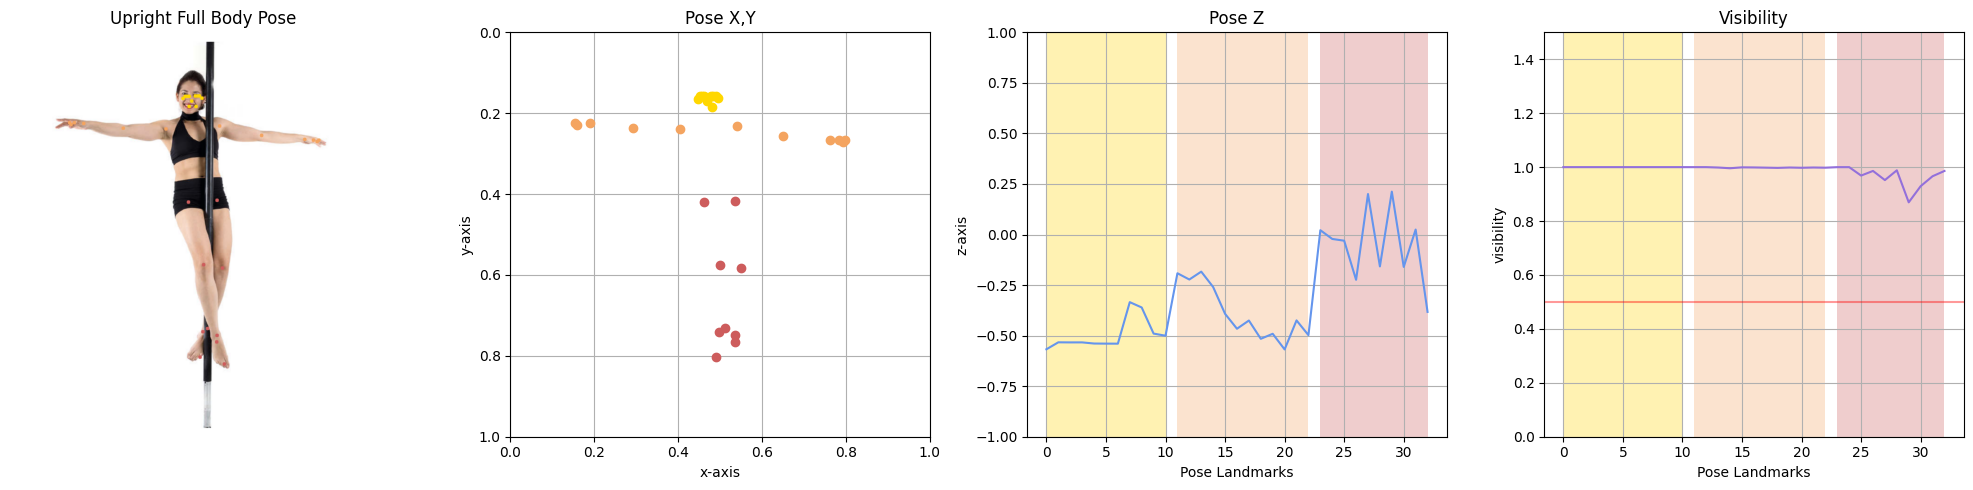

In [41]:
df2 = pd.read_csv('data/processed/static-pole-fitness/00002.csv')
orig_img2 = cv2.imread('data/processed/static-pole-fitness/00002.png')

x2 = df2['x'].to_numpy()
y2 = df2['y'].to_numpy()
z2 = df2['z'].to_numpy()
v2 = df2['v'].to_numpy()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

ax1.set_title("Upright Full Body Pose")
ax1.imshow(orig_img2)
ax1.axis(False)

ax2.set_title("Pose X,Y")
ax2.plot(x2[0:10], y2[0:10], color=mcolors.CSS4_COLORS['gold'], label="head", marker='o', linestyle='None')
ax2.plot(x2[11:22], y2[11:22], color=mcolors.CSS4_COLORS['sandybrown'], label="upper body", marker='o', linestyle='None')
ax2.plot(x2[23:32], y2[23:32], color=mcolors.CSS4_COLORS['indianred'], label="lower body", marker='o', linestyle='None')
ax2.set_xlabel("x-axis")
ax2.set_ylabel("y-axis")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.invert_yaxis() #For better visualization
ax2.grid()

ax3.set_title("Pose Z")
ax3.axvspan(0, 10, facecolor=mcolors.CSS4_COLORS['gold'], alpha=0.3, label="head")
ax3.axvspan(11, 22, facecolor=mcolors.CSS4_COLORS['sandybrown'], alpha=0.3, label="upper body")
ax3.axvspan(23, 32, facecolor=mcolors.CSS4_COLORS['indianred'], alpha=0.3, label="lower body")
ax3.plot(z2, color=mcolors.CSS4_COLORS['cornflowerblue'], label="z-axis")
ax3.set_xlabel("Pose Landmarks")
ax3.set_ylabel("z-axis")
ax3.set_ylim(-1, 1)
ax3.grid()

ax4.set_title("Visibility")
ax4.plot(v2, color=mcolors.CSS4_COLORS['mediumpurple'], label="visibility")
ax4.axvspan(0, 10, facecolor=mcolors.CSS4_COLORS['gold'], alpha=0.3, label="head")
ax4.axvspan(11, 22, facecolor=mcolors.CSS4_COLORS['sandybrown'], alpha=0.3, label="upper body")
ax4.axvspan(23, 32, facecolor=mcolors.CSS4_COLORS['indianred'], alpha=0.3, label="lower body")
ax4.axhline(y=0.5, color='red', alpha=0.4)
ax4.set_xlabel("Pose Landmarks")
ax4.set_ylabel("visibility")
ax4.set_ylim(0, 1.5)
ax4.grid()

fig.tight_layout()
plt.show()

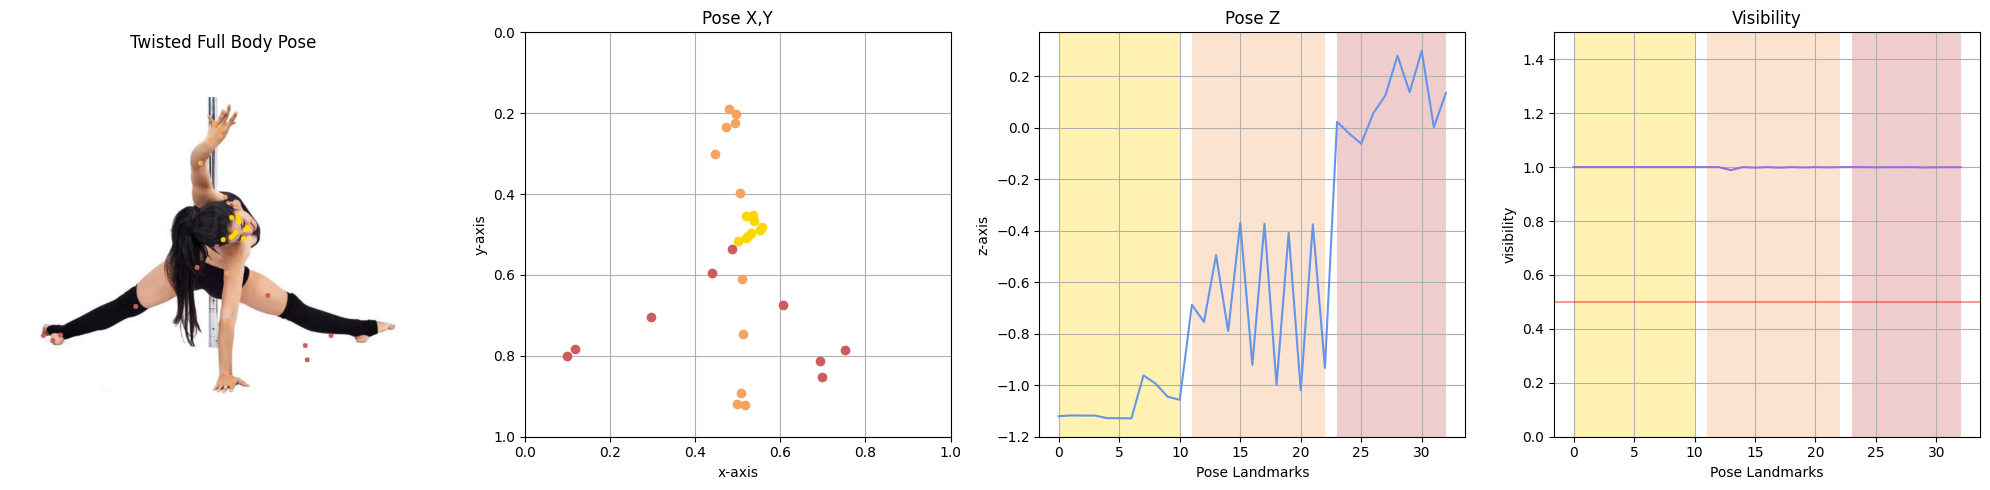

In [45]:
df3 = pd.read_csv('data/processed/static-pole-fitness/00101.csv')
orig_img3 = cv2.imread('data/processed/static-pole-fitness/00101.png')

x3 = df3['x'].to_numpy()
y3 = df3['y'].to_numpy()
z3 = df3['z'].to_numpy()
v3 = df3['v'].to_numpy()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

ax1.set_title("Twisted Full Body Pose")
ax1.imshow(orig_img3)
ax1.axis(False)

ax2.set_title("Pose X,Y")
ax2.plot(x3[0:10], y3[0:10], color=mcolors.CSS4_COLORS['gold'], label="head", marker='o', linestyle='None')
ax2.plot(x3[11:22], y3[11:22], color=mcolors.CSS4_COLORS['sandybrown'], label="upper body", marker='o', linestyle='None')
ax2.plot(x3[23:32], y3[23:32], color=mcolors.CSS4_COLORS['indianred'], label="lower body", marker='o', linestyle='None')
ax2.set_xlabel("x-axis")
ax2.set_ylabel("y-axis")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.invert_yaxis() #For better visualization
ax2.grid()

ax3.set_title("Pose Z")
ax3.axvspan(0, 10, facecolor=mcolors.CSS4_COLORS['gold'], alpha=0.3, label="head")
ax3.axvspan(11, 22, facecolor=mcolors.CSS4_COLORS['sandybrown'], alpha=0.3, label="upper body")
ax3.axvspan(23, 32, facecolor=mcolors.CSS4_COLORS['indianred'], alpha=0.3, label="lower body")
ax3.plot(z3, color=mcolors.CSS4_COLORS['cornflowerblue'], label="z-axis")
ax3.set_xlabel("Pose Landmarks")
ax3.set_ylabel("z-axis")
ax3.grid()

ax4.set_title("Visibility")
ax4.plot(v3, color=mcolors.CSS4_COLORS['mediumpurple'], label="visibility")
ax4.axvspan(0, 10, facecolor=mcolors.CSS4_COLORS['gold'], alpha=0.3, label="head")
ax4.axvspan(11, 22, facecolor=mcolors.CSS4_COLORS['sandybrown'], alpha=0.3, label="upper body")
ax4.axvspan(23, 32, facecolor=mcolors.CSS4_COLORS['indianred'], alpha=0.3, label="lower body")
ax4.axhline(y=0.5, color='red', alpha=0.4)
ax4.set_xlabel("Pose Landmarks")
ax4.set_ylabel("visibility")
ax4.set_ylim(0, 1.5)
ax4.grid()

fig.tight_layout()
plt.show()

Here we can observe that pose data are flipped vertically for cropped images as well.

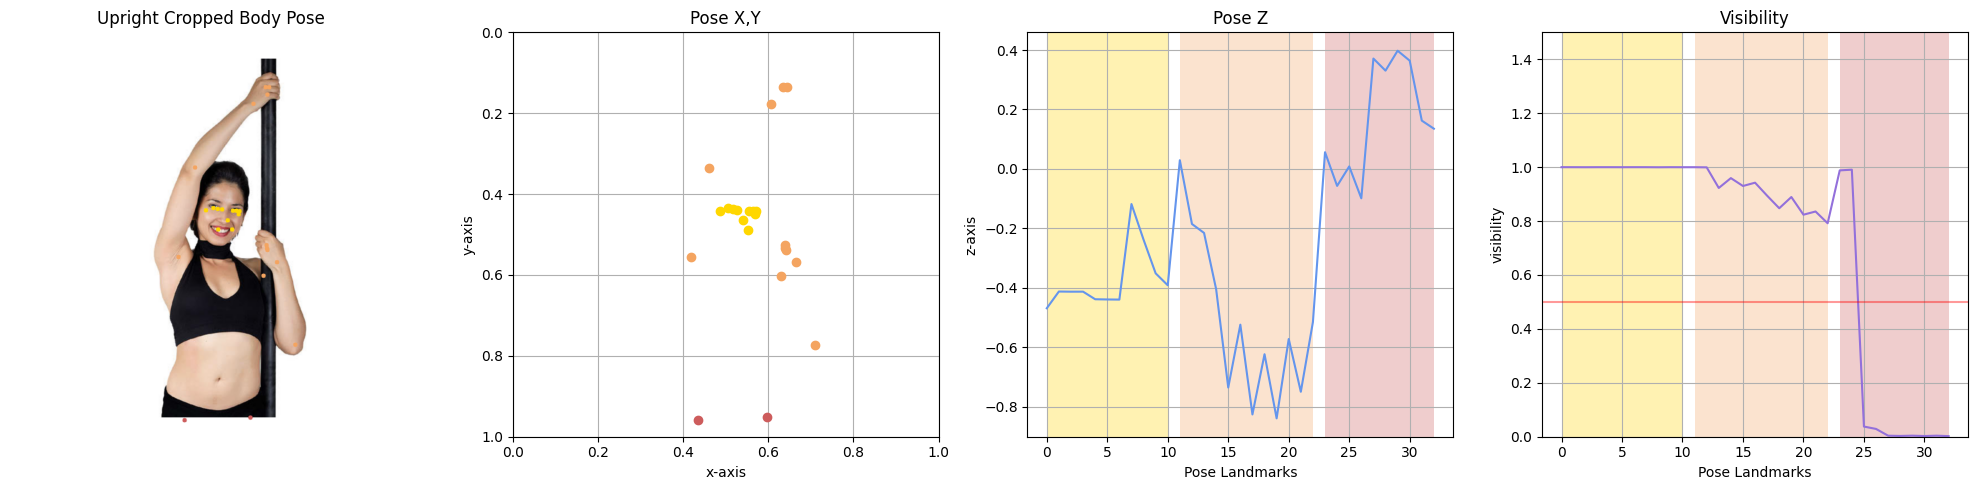

In [46]:
df4 = pd.read_csv('data/processed/static-pole-fitness/00008.csv')
orig_img4 = cv2.imread('data/processed/static-pole-fitness/00008.png')

x4 = df4['x'].to_numpy()
y4 = df4['y'].to_numpy()
z4 = df4['z'].to_numpy()
v4 = df4['v'].to_numpy()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

ax1.set_title("Upright Cropped Body Pose")
ax1.imshow(orig_img4)
ax1.axis(False)

ax2.set_title("Pose X,Y")
ax2.plot(x4[0:10], y4[0:10], color=mcolors.CSS4_COLORS['gold'], label="head", marker='o', linestyle='None')
ax2.plot(x4[11:22], y4[11:22], color=mcolors.CSS4_COLORS['sandybrown'], label="upper body", marker='o', linestyle='None')
ax2.plot(x4[23:32], y4[23:32], color=mcolors.CSS4_COLORS['indianred'], label="lower body", marker='o', linestyle='None')
ax2.set_xlabel("x-axis")
ax2.set_ylabel("y-axis")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.invert_yaxis() #For better visualization
ax2.grid()

ax3.set_title("Pose Z")
ax3.axvspan(0, 10, facecolor=mcolors.CSS4_COLORS['gold'], alpha=0.3, label="head")
ax3.axvspan(11, 22, facecolor=mcolors.CSS4_COLORS['sandybrown'], alpha=0.3, label="upper body")
ax3.axvspan(23, 32, facecolor=mcolors.CSS4_COLORS['indianred'], alpha=0.3, label="lower body")
ax3.plot(z4, color=mcolors.CSS4_COLORS['cornflowerblue'], label="z-axis")
ax3.set_xlabel("Pose Landmarks")
ax3.set_ylabel("z-axis")
ax3.grid()

ax4.set_title("Visibility")
ax4.plot(v4, color=mcolors.CSS4_COLORS['mediumpurple'], label="visibility")
ax4.axvspan(0, 10, facecolor=mcolors.CSS4_COLORS['gold'], alpha=0.3, label="head")
ax4.axvspan(11, 22, facecolor=mcolors.CSS4_COLORS['sandybrown'], alpha=0.3, label="upper body")
ax4.axvspan(23, 32, facecolor=mcolors.CSS4_COLORS['indianred'], alpha=0.3, label="lower body")
ax4.axhline(y=0.5, color='red', alpha=0.4)
ax4.set_xlabel("Pose Landmarks")
ax4.set_ylabel("visibility")
ax4.set_ylim(0, 1.5)
ax4.grid()

fig.tight_layout()
plt.show()

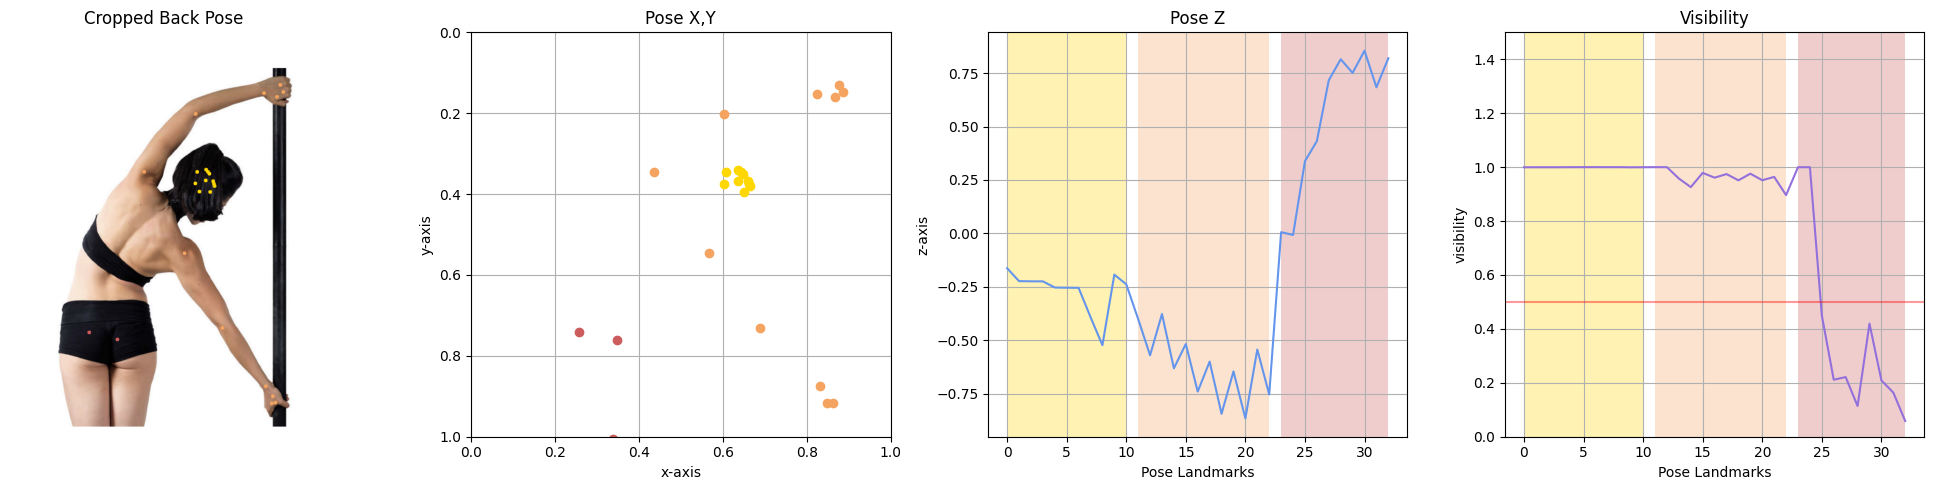

In [63]:
df5 = pd.read_csv('data/processed/static-pole-fitness/00018.csv')
orig_img5 = cv2.imread('data/processed/static-pole-fitness/00018.png')

x5 = df5['x'].to_numpy()
y5 = df5['y'].to_numpy()
z5 = df5['z'].to_numpy()
v5 = df5['v'].to_numpy()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

ax1.set_title("Cropped Back Pose")
ax1.imshow(orig_img5)
ax1.axis(False)

ax2.set_title("Pose X,Y")
ax2.plot(x5[0:10], y5[0:10], color=mcolors.CSS4_COLORS['gold'], label="head", marker='o', linestyle='None')
ax2.plot(x5[11:22], y5[11:22], color=mcolors.CSS4_COLORS['sandybrown'], label="upper body", marker='o', linestyle='None')
ax2.plot(x5[23:32], y5[23:32], color=mcolors.CSS4_COLORS['indianred'], label="lower body", marker='o', linestyle='None')
ax2.set_xlabel("x-axis")
ax2.set_ylabel("y-axis")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.invert_yaxis() #For better visualization
ax2.grid()

ax3.set_title("Pose Z")
ax3.axvspan(0, 10, facecolor=mcolors.CSS4_COLORS['gold'], alpha=0.3, label="head")
ax3.axvspan(11, 22, facecolor=mcolors.CSS4_COLORS['sandybrown'], alpha=0.3, label="upper body")
ax3.axvspan(23, 32, facecolor=mcolors.CSS4_COLORS['indianred'], alpha=0.3, label="lower body")
ax3.plot(z5, color=mcolors.CSS4_COLORS['cornflowerblue'], label="z-axis")
ax3.set_xlabel("Pose Landmarks")
ax3.set_ylabel("z-axis")
ax3.grid()

ax4.set_title("Visibility")
ax4.plot(v5, color=mcolors.CSS4_COLORS['mediumpurple'], label="visibility")
ax4.axvspan(0, 10, facecolor=mcolors.CSS4_COLORS['gold'], alpha=0.3, label="head")
ax4.axvspan(11, 22, facecolor=mcolors.CSS4_COLORS['sandybrown'], alpha=0.3, label="upper body")
ax4.axvspan(23, 32, facecolor=mcolors.CSS4_COLORS['indianred'], alpha=0.3, label="lower body")
ax4.axhline(y=0.5, color='red', alpha=0.4)
ax4.set_xlabel("Pose Landmarks")
ax4.set_ylabel("visibility")
ax4.set_ylim(0, 1.5)
ax4.grid()

fig.tight_layout()
plt.show()

Here we can also see the differences between the Z and V values of resampled images.

- The mean of $x$ and $y$ values vary by `+/- 0.001`, while the mean of $z$ and $v$ vary by `+/- 0.01`. This suggests that the pose estimation model is not very sensitive to these small variations.

In [58]:
df1_2 = pd.read_csv('data/processed/static-pole-fitness-2/00001.csv')
df2_2 = pd.read_csv('data/processed/static-pole-fitness-2/00002.csv')
df3_2 = pd.read_csv('data/processed/static-pole-fitness-2/00101.csv')
df4_2 = pd.read_csv('data/processed/static-pole-fitness-2/00008.csv')
df5_2 = pd.read_csv('data/processed/static-pole-fitness-2/00018.csv')

In [65]:
df1.describe(), df1_2.describe()

(               x          y          z          v
 count  33.000000  33.000000  33.000000  33.000000
 mean    0.392377   0.575086  -0.002400   0.822233
 std     0.109319   0.238033   0.403905   0.296702
 min     0.171189   0.095684  -0.788713   0.168217
 25%     0.286873   0.529550  -0.215883   0.658142
 50%     0.443061   0.703174   0.052947   0.989762
 75%     0.457780   0.773623   0.137049   0.999731
 max     0.506020   0.791948   0.733252   0.999974,
                x          y          z          v
 count  33.000000  33.000000  33.000000  33.000000
 mean    0.392779   0.572583  -0.025901   0.838476
 std     0.109520   0.236598   0.386758   0.275243
 min     0.170152   0.096144  -0.814179   0.232454
 25%     0.287361   0.531086  -0.216462   0.726408
 50%     0.444942   0.675547   0.028465   0.993761
 75%     0.458550   0.775361   0.157258   0.999725
 max     0.509115   0.794538   0.627308   0.999983)

In [66]:
df2.describe(), df2_2.describe()

(               x          y          z          v
 count  33.000000  33.000000  33.000000  33.000000
 mean    0.486203   0.343946  -0.322066   0.988646
 std     0.163935   0.229386   0.229789   0.026704
 min     0.153912   0.157452  -0.568265   0.869420
 25%     0.457456   0.170142  -0.515768   0.995831
 50%     0.489489   0.237634  -0.392142   0.998822
 75%     0.535348   0.420034  -0.183546   0.999994
 max     0.798057   0.820072   0.211956   0.999998,
                x          y          z          v
 count  33.000000  33.000000  33.000000  33.000000
 mean    0.485974   0.343954  -0.338209   0.987402
 std     0.164572   0.229679   0.238029   0.029626
 min     0.151328   0.157028  -0.591801   0.856741
 25%     0.457916   0.169462  -0.538892   0.996173
 50%     0.489928   0.237487  -0.409191   0.999063
 75%     0.535051   0.420578  -0.200137   0.999994
 max     0.797395   0.819547   0.217054   0.999998)

In [67]:
df3.describe(), df3_2.describe()

(               x          y          z          v
 count  33.000000  33.000000  33.000000  33.000000
 mean    0.487787   0.582255  -0.578333   0.999353
 std     0.147437   0.220355   0.512439   0.001933
 min     0.078529   0.190514  -1.129163   0.989024
 25%     0.486053   0.457979  -1.045349   0.999667
 50%     0.512488   0.515524  -0.754666   0.999977
 75%     0.536756   0.784998  -0.023087   1.000000
 max     0.752962   0.920649   0.298350   1.000000,
                x          y          z          v
 count  33.000000  33.000000  33.000000  33.000000
 mean    0.487853   0.582138  -0.562547   0.990975
 std     0.143959   0.218355   0.540589   0.018575
 min     0.093093   0.187192  -1.126982   0.901165
 25%     0.479018   0.456459  -1.045015   0.986624
 50%     0.513809   0.519683  -0.783978   0.999721
 75%     0.540427   0.782128  -0.011610   0.999999
 max     0.720456   0.923235   0.348960   1.000000)

In [68]:
df4.describe(), df4_2.describe()

(               x          y          z          v
 count  33.000000  33.000000  33.000000  33.000000
 mean    0.540094   0.724474  -0.260712   0.724120
 std     0.094407   0.484873   0.353244   0.413949
 min     0.354353   0.135862  -0.838466   0.002232
 25%     0.487121   0.440721  -0.468288   0.791794
 50%     0.552643   0.526617  -0.391085   0.942299
 75%     0.631076   0.958395   0.008541   0.999709
 max     0.709632   1.622320   0.397625   0.999837,
                x          y          z          v
 count  33.000000  33.000000  33.000000  33.000000
 mean    0.542117   0.724941  -0.276989   0.729774
 std     0.092407   0.483257   0.366585   0.415343
 min     0.363877   0.134475  -0.912712   0.002836
 25%     0.489437   0.443166  -0.468893   0.788751
 50%     0.553153   0.526197  -0.409938   0.957841
 75%     0.631052   0.957104  -0.014824   0.999749
 max     0.709044   1.623211   0.394335   0.999868)

In [69]:
df5.describe(), df5_2.describe()

(               x          y          z          v
 count  33.000000  33.000000  33.000000  33.000000
 mean    0.565548   0.639127  -0.151784   0.799320
 std     0.237746   0.391350   0.529361   0.333715
 min     0.184056   0.130379  -0.864282   0.058304
 25%     0.338599   0.345331  -0.542671   0.896175
 50%     0.635992   0.394895  -0.252566   0.975763
 75%     0.689521   0.916868   0.006171   0.999692
 max     0.886859   1.273407   0.854347   0.999898,
                x          y          z          v
 count  33.000000  33.000000  33.000000  33.000000
 mean    0.566804   0.640761  -0.151908   0.794412
 std     0.238664   0.393579   0.563792   0.341024
 min     0.175098   0.131201  -0.844722   0.053305
 25%     0.342242   0.344738  -0.569705   0.904399
 50%     0.636625   0.394332  -0.294856   0.971110
 75%     0.696071   0.919925   0.007306   0.999681
 max     0.888224   1.280849   0.961142   0.999902)

### Data Trends and Limitations

1. The x and y values estimated from landmarks from the training data are sufficient for pose estimation, albeit not accurate. However, the main regions (head, upper body, lower body) are distinct enough for training.
2. There are noticeable errors on some landmarks, but the overall accuracy of the pose estimation is acceptable for this project.
3. The visibility of a pose drops significantly when it cannot be detected. Visibility values below 0.5 can be discarded to improve the accuracy of the pose estimation.
4. Resampling an image does not necessarily improve the pose's visibility, but it can cause a slight variation in the visibility values. This should be taken into account when using pose estimation models on resampled images.
5. Front and back poses cannot be differentiated using only the z and visibility values. Therefore, additional features, such as categorical labels, can be helpful to differentiate between these poses.

## References

* https://github.com/google/mediapipe
* https://www.goodreads.com/book/show/43151907-pole-dance-fitness